# Introduction
- ref
> https://www.kaggle.com/robikscube/exploring-molecular-properties-data

- model: lightgbm

# Import everything I nead :)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# Data Preparation
- nb11 で作ったdataframe

In [2]:
# notebook No.
nb = 13

In [3]:
path = './dataframe/20190614_nb12_train.csv'
df_train = pd.read_csv(path)

df_train.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_count,x_0,y_0,z_0,...,type_1_JHH,type_1_JHN,type_0,type_1,atom_0_H,atom_1_C,atom_1_H,atom_1_N,atom_0,atom_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,5,0.002150,-0.006031,0.001976,...,0,0,H,C,1,1,0,0,H,C
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,5,0.002150,-0.006031,0.001976,...,1,0,H,C,1,0,1,0,H,H
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,5,0.002150,-0.006031,0.001976,...,1,0,H,H,1,0,1,0,H,H
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,5,0.002150,-0.006031,0.001976,...,1,0,H,C,1,0,1,0,H,H
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,5,1.011731,1.463751,0.000277,...,0,0,H,C,1,1,0,0,H,C


In [4]:
path = './dataframe/20190614_nb12_test.csv'
df_test = pd.read_csv(path)

# LightGBM - 5 Fold Cross Valified

In [5]:
# feature_list
df_train.columns

Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant', 'atom_count', 'x_0', 'y_0', 'z_0', 'x_1',
       'y_1', 'z_1', 'dist', 'dist_to_type_mean', '1JHC', '1JHN', '2JHC',
       '2JHH', '2JHN', '3JHC', '3JHH', '3JHN', 'type_0_1', 'type_0_2',
       'type_0_3', 'type_1_JHC', 'type_1_JHH', 'type_1_JHN', 'type_0',
       'type_1', 'atom_0_H', 'atom_1_C', 'atom_1_H', 'atom_1_N', 'atom_0',
       'atom_1'],
      dtype='object')

## params

In [11]:
# Configurables
FEATURES = ['atom_index_0', 'atom_index_1',
            'x_0', 'y_0', 'z_0',
            'x_1', 'y_1', 'z_1',
            'atom_1_H', 'atom_1_C', 'atom_1_N',
            'dist', 'dist_to_type_mean',
            'atom_count',
            '1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN',
            'type_0_1', 'type_0_2', 'type_0_3',
            'type_1_JHC', 'type_1_JHH', 'type_1_JHN'
           ]
TARGET = 'scalar_coupling_constant'
N_ESTIMATORS = 2000  # 決定木の数
VERBOSE = 500
EARLY_STOPPING_ROUNDS = 200 # 200回学習して性能の向上がなければ学習をやめる
RANDOM_STATE = 529

X = df_train[FEATURES]
X_test = df_test[FEATURES]
y = df_train[TARGET]

# Apply

In [12]:
%%time
lgb_params = {'num_leaves': 128,
              'min_child_samples': 64,
              'objective': 'regression',
              'max_depth': 6,
              'learning_rate': 0.1,
              "boosting_type": "gbdt",
              "subsample_freq": 1,
              "subsample": 0.9,
              "bagging_seed": 11,
              "metric": 'mae',
              "verbosity": -1,
              'reg_alpha': 0.1,
              'reg_lambda': 0.4,
              'colsample_bytree': 1.0
         }

# ----- set params -----
RUN_LGB = True
# ----------------------
if RUN_LGB:
    n_fold = 5
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=RANDOM_STATE)

    # Setup arrays for storing results
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    
    # Train the model
    for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        model = lgb.LGBMRegressor(**lgb_params, n_estimators = N_ESTIMATORS, n_jobs = -1)
        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  eval_metric='mae',
                  verbose=VERBOSE,
                  early_stopping_rounds=EARLY_STOPPING_ROUNDS)

        y_pred_valid = model.predict(X_valid)
        y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
        
        # feature importance
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = FEATURES
        fold_importance["importance"] = model.feature_importances_
        fold_importance["fold"] = fold_n + 1
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

        prediction /= folds.n_splits
        scores.append(mean_absolute_error(y_valid, y_pred_valid))
        print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
        oof[valid_idx] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))
        prediction += y_pred
        

Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 2.13427	valid_1's l1: 2.1451
[1000]	training's l1: 2.05223	valid_1's l1: 2.07213
[1500]	training's l1: 2.00098	valid_1's l1: 2.02932
[2000]	training's l1: 1.96387	valid_1's l1: 1.9998
Did not meet early stopping. Best iteration is:
[2000]	training's l1: 1.96387	valid_1's l1: 1.9998
CV mean score: 1.9998, std: 0.0000.
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 2.13618	valid_1's l1: 2.14384
[1000]	training's l1: 2.05219	valid_1's l1: 2.06903
[1500]	training's l1: 2.00062	valid_1's l1: 2.02591
[2000]	training's l1: 1.96318	valid_1's l1: 1.99609
Did not meet early stopping. Best iteration is:
[2000]	training's l1: 1.96318	valid_1's l1: 1.99609
CV mean score: 1.9986, std: 0.0017.
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 2.13674	valid_1's l1: 2.15121
[1000]	training's l1: 2.05356	valid_1's l1: 2.07673
[1500]	training's l1: 2.0

## save Result

In [13]:
if RUN_LGB:
    # Save Prediction and name appropriately
    dir_save = './output/'
    submission_csv_name = dir_save + 'nb{}_submission_lgb_{}folds_{}CV.csv'.format(nb, n_fold, np.mean(scores))
    oof_csv_name = dir_save + 'nb{}_oof_lgb_{}folds_{}CV.csv'.format(nb, n_fold, np.mean(scores))
    fi_csv_name = dir_save + 'nb{}_fi_lgb_{}folds_{}CV.csv'.format(nb, n_fold, np.mean(scores))

    print('Saving LGB Submission as:')
    print(submission_csv_name)
    ss = pd.read_csv( './input/champs-scalar-coupling/sample_submission.csv')
    ss['scalar_coupling_constant'] = prediction
    ss.to_csv(submission_csv_name, index=False)
    ss.head()
    # OOF
    oof_df = df_train[['id','molecule_name','scalar_coupling_constant']].copy()
    oof_df['oof_pred'] = oof
    oof_df.to_csv(oof_csv_name, index=False)
    # Feature Importance
    feature_importance.to_csv(fi_csv_name, index=False)

Saving LGB Submission as:
./output/nb13_submission_lgb_5folds_1.9995990985933818CV.csv


## Feature Importance

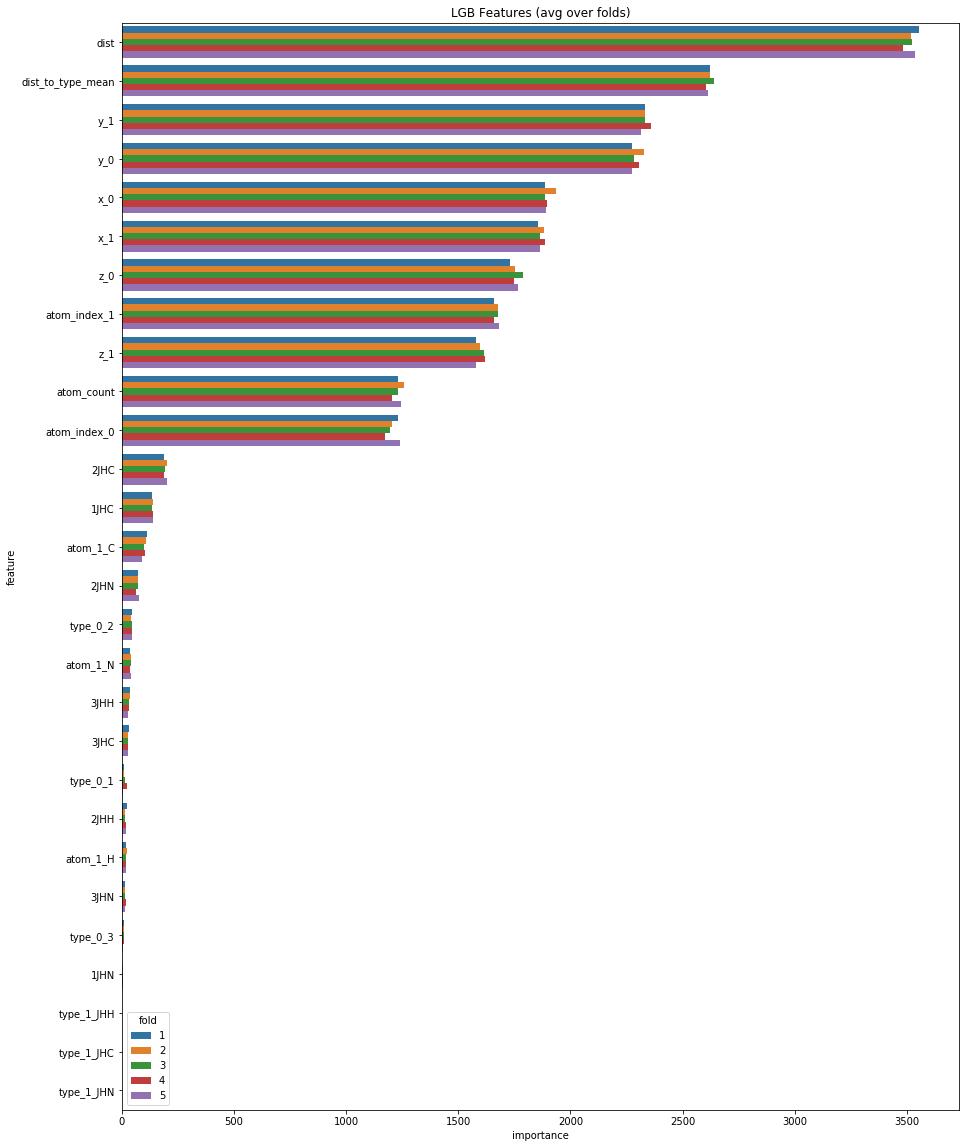

In [14]:
if RUN_LGB:
    # Plot feature importance as done in https://www.kaggle.com/artgor/artgor-utils
    feature_importance["importance"] /= folds.n_splits
    cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index

    best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

    plt.figure(figsize=(15, 20));
    ax = sns.barplot(x="importance",
                y="feature",
                hue='fold',
                data=best_features.sort_values(by="importance", ascending=False));
    plt.title('LGB Features (avg over folds)');